# Am I The A-hole Predictor Project

This project is based on one of Reddit's most popular section: <a href="https://www.reddit.com/r/AmItheAsshole/">r/AmITheAsshole</a>. This subreddit (AITA for short) has a simple premise of having people post about social experiences where they're unsure if they're the one at fault or not. Redditors participate in deciding their judgement, commenting on the situation, giving a brief summary of what they think is going on and argumenting for each of the valid judgements:

- **YTA** (You're the A-hole)
- **NTA** (Not the A-hole, but the other person is)
- **ESH** (Everyone Sucks Here)
- **NAH** (No A-holes Here)

People vote in their comments, and after 18 hours, a flair is given to each post with the verdict of the public, which then usually translates to the original posters reacting to their judgement, for better or worse (and this is where this subreddit gets one of the juiciest comment sections on the entire website!). However, this being both Reddit and the internet, there are some biases included, and the crowd allegedly tends to pick certain verdicts when the story has some buzzwords or characters which are not as favored in the internet, such as: mothers-in-law, pregnant people, childen being loud, among many others, as well as certain situations where the subreddit is pretty vocal about defending, specially when it includes people asking for help when there's no legal obligation to do so.

In this project, I took this perceived notion of being able to predict the outcome when the story is told in a certain way or with certain participates, and a dataset of 150,000 submissions was obtained and processed to obtain some descriptive statistics about posts based on Reddit activity such as comments and up/downvotes to characterize the posts, and build a machine learning model to predict the verdict of a user input text telling a story.

**Import statements**

In [54]:
import pandas as pd
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Loading the dataset

The dataset was obtained from a script which uses two Reddit APIs to obtain posts and then pull information about each of them.

In [55]:
df = pd.read_csv(os.path.join("../reddit_scraper/reddit_posts1.csv"))

In [56]:
df.head()

,title,id,score,upvote_ratio,url,num_comments,body,created,edited,verdict,over_18
0,AITA because I don’t agree with my mum’s friend,rt9xvc,1,1.00,https://www.reddit.com/r/AmItheAsshole/comment...,1,[removed],2021-12-31 23:58:36,1641006108.0,NaN,False
1,AITA for refusing to visit my father because o...,rt9vwd,1873,0.97,https://www.reddit.com/r/AmItheAsshole/comment...,226,"Without going into novel length, my father cur...",2021-12-31 23:55:16,False,Not the A-hole,False
2,WIBTA still for ruining our family movie night...,rt9vtn,1,1.00,https://www.reddit.com/r/AmItheAsshole/comment...,1,[removed],2021-12-31 23:55:08,False,NaN,False
3,WIBTA if I told a toddler's mom to have a bett...,rt9v3v,9,0.74,https://www.reddit.com/r/AmItheAsshole/comment...,22,I'm sitting in a local Applebee's and across f...,2021-12-31 23:53:53,False,Everyone Sucks,False
4,AITA for being completely over my relationship...,rt9t6e,1,1.00,https://www.reddit.com/r/AmItheAsshole/comment...,1,[removed],2021-12-31 23:50:47,False,NaN,False


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   title         100000 non-null  object 
 1   id            100000 non-null  object 
 2   score         100000 non-null  int64  
 3   upvote_ratio  100000 non-null  float64
 4   url           100000 non-null  object 
 5   num_comments  100000 non-null  int64  
 6   body          99998 non-null   object 
 7   created       100000 non-null  object 
 8   edited        100000 non-null  object 
 9   verdict       26468 non-null   object 
 10  over_18       100000 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 7.7+ MB


The fields available were decided based on the <a href="https://praw.readthedocs.io/en/latest/code_overview/models/submission.html?highlight=submission">PRAW docs</a> for both the ML model and analytics:
- **title**: title of the submission
- **id**: ID of the submission
- **score**: The number of upvotes for the submission.
- **upvote_ratio**: The percentage of upvotes from all votes on the submission.
- **url**: The URL the submission links to, or the permalink if a selfpost.
- **num_comments**: The number of comments on the submission.
- **body (renamed from selftext)**: The submissions’ selftext - an empty string if a link post. 
- **created**: Time the submission was created, represented in Unix Time.
- **edited**: Whether or not the submission has been edited.
- **verdict** (renamed from link_flair_text): The link flair’s text content, or None if not flaired.
- **over_18**: Whether or not the submission has been marked as NSFW.

The main fields for the model are the content body of the submission and the verdict, which comes from the submission flair, which is given after the 18 hours of people commenting on the post.

### Cleaning

For the analysis, we will remove posts with tags outside the verdicts (mod posts or without a flair). Also, "Not enough info" posts will be removed as well, as they're considered invalid from the submission point of view.

The edited column has a mix of datatypes, so we'll change it to a boolean type to know if the post was edited or not.

In [63]:
df.verdict.value_counts()

Not the A-hole     18759
Asshole             3896
No A-holes here     1419
Everyone Sucks      1058
Not enough info      560
TL;DR                396
UPDATE               374
Open Forum             2
Talk ENDED             2
META                   1
Mods Needed!           1
Name: verdict, dtype: int64

In [57]:
nan = np.nan
clean_df = df.query("verdict not in ['TL;DR', 'UPDATE', @nan, 'Talk ENDED', 'Open Forum', 'Mods Needed!', 'META', 'Not enough info']")

In [58]:
is_edited = []

for i in clean_df.edited.values:
    if i == 'False':
        column_value = False
    else:
        column_value = True
    is_edited.append(column_value)

In [59]:
clean_df.insert(8, 'is_edited', is_edited)

In [60]:
clean_df = clean_df.drop(columns=["edited"])

In [62]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25132 entries, 1 to 99997
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         25132 non-null  object 
 1   id            25132 non-null  object 
 2   score         25132 non-null  int64  
 3   upvote_ratio  25132 non-null  float64
 4   url           25132 non-null  object 
 5   num_comments  25132 non-null  int64  
 6   body          25132 non-null  object 
 7   created       25132 non-null  object 
 8   is_edited     25132 non-null  bool   
 9   verdict       25132 non-null  object 
 10  over_18       25132 non-null  bool   
dtypes: bool(2), float64(1), int64(2), object(6)
memory usage: 2.0+ MB


After cleaning up, we lost nearly 75% of the original posts, which didn't have a flair as seen in the initial assessment. 

# Removed posts proportion

In [44]:
total_removed_posts = clean_df.query("body in ['[deleted]', '[removed]']").id.count()

In [66]:
pctg_verdicts = clean_df.query("body in ['[deleted]', '[removed]']").verdict.value_counts() / total_removed_posts * 100

In [76]:
## general parameters for plotting
legends = list(clean_df.verdict.unique().astype("str"))
ind = np.arange(len(pctg_verdicts))
ticks = np.arange(len(labels))
width = 0.9

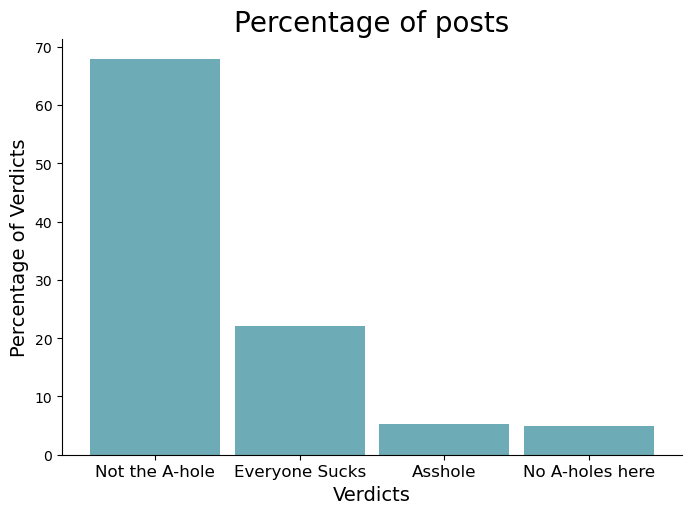

In [80]:
## plotting
plt.figure(figsize=(8,5.5), dpi=100)
plt.bar(ind, pctg_verdicts, width, label = "Percentage of posts", color=(0.33, 0.62, 0.67, 0.85))

plt.ylabel('Percentage of Verdicts', fontsize=14)
plt.xlabel('Verdicts', fontsize=14)
plt.title('Percentage of posts', fontsize=20)
locations = ticks
plt.xticks(locations, labels, fontsize=12)
plt.yticks()
sns.despine();

# General description

In [174]:
clean_df.describe()

,score,upvote_ratio,num_comments
count,21377.000000,21377.000000,21377.000000
mean,615.662113,0.800828,118.628152
std,2291.983142,0.140574,372.662983
min,0.000000,0.140000,3.000000
25%,6.000000,0.710000,16.000000
50%,16.000000,0.830000,28.000000
75%,99.000000,0.920000,62.000000
max,41057.000000,1.000000,8053.000000


# Over 18 posts

In [52]:
clean_df.groupby("verdict").over_18.sum()

verdict
Asshole             19
Everyone Sucks       7
No A-holes here     11
Not the A-hole     119
Name: over_18, dtype: int64

# General overview of verdicts

In [33]:
total_posts = clean_df.id.count()
total_posts

25132

In [43]:
clean_df.verdict.value_counts() / total_posts * 100

Not the A-hole     74.641891
Asshole            15.502149
No A-holes here     5.646188
Everyone Sucks      4.209772
Name: verdict, dtype: float64

# Upvote ratio

In [176]:
clean_df.groupby("verdict").upvote_ratio.mean()

verdict
Asshole            0.699498
Everyone Sucks     0.745308
No A-holes here    0.759542
Not the A-hole     0.826118
Name: upvote_ratio, dtype: float64

# Number of comments

In [177]:
clean_df.groupby("verdict").num_comments.mean()

verdict
Asshole            193.902868
Everyone Sucks     110.381279
No A-holes here     59.662848
Not the A-hole     109.272593
Name: num_comments, dtype: float64

# Number of upvotes

In [178]:
clean_df.groupby("verdict").score.mean()

verdict
Asshole            505.537810
Everyone Sucks     321.625571
No A-holes here    172.189853
Not the A-hole     685.821911
Name: score, dtype: float64

# Word Cloud Files

In [179]:
nta_df = clean_df.query("verdict == 'Not the A-hole'").sort_values(by="num_comments", ascending=False).head(500)

In [180]:
yta_df = clean_df.query("verdict == 'Asshole'").sort_values(by="num_comments", ascending=False).head(500)

In [181]:
nta_text = []

for text in nta_df.body.values:
    with open(os.path.join("../analytics/nta_text.txt"), "a+") as f:
        f.write(text)

In [182]:
yta_text = []

for text in yta_df.body.values:
    with open(os.path.join("../analytics/yta_text.txt"), "a+") as f:
        f.write(text)

## Discussion
This project represents the end of the Nanodegree, and was created from scratch thinking of something that could be both fun and could provide insight from a popular website that I personally browse everyday. It was challenging, and tries to cover a little bit of everything learned through this course. The dataset was obtained from scratch using Reddit APIs, which was a whole world to explore on its own and took a lot of testing to get the information with the desired format and using the right filters. 

The machine learning pipeline was similar to what was covered during the course, but proved to be even more rewarding when using original data and iterating through the script to improve its metrics for a better model. The original dataset was biased towards a particular verdict, so several things were tested before the final version which improved its metrics from the very unbalanced first one, which again had high f-score for the class with bigger size, but really low on all the others. A few things were implemented, like using balanced classes, trying different dataset sizes, and looking through different parameters to test with GridSearch. In the end, the model had higher metrics, and since the classes were balanced, the accuracy improved overall. It's not perfect (yet), due to the complexity of this challenge, which might be a bit ambitious in wanting to classify based on internet users moral compass, which is an issue on its own.